# Introduction for the problem

The main components of the problem proposed by Strangeworks are to work on a Max cut problem, starting from a graphic representation (graphs) of the problem, this problem proposes to work mainly with 4 binary nodes. With this representation we start with the QAOA process to find the minimum energy of the Hamiltonian. With this in mind we are looking to know the costs of doing it by this method and to know if it is feasible compared to the classical method.

The explanation of each step of the problem will be explained below and is heavily influenced by the strangeworks GitHub and qiskit.

## Max cut

The Max-Cut problem consists of dividing the nodes of the graph into two sets in such a way that the number of edges between the sets is maximized.

For this case a 4-node problem is going to be used, each node can be assigned with a value that could be either "0" or "1" (binary value). This means that you can have 16 possible placements or solutions, we can express that number by the following equation $2^N$, where N is the number of nodes. The equation indicates that the number of solutions grows exponentially depending on the nodes to be used.



## QAOA

Quantum Approximate Optimization Algorithm is a quantum algorithm that attempts to solve such combinatorial problems.

It is a variational algorithm that uses a unitary $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ characterized by the parameters 
$(\boldsymbol{\beta}, \boldsymbol{\gamma})$ to prepare a quantum state $\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle$. 
The goal of the algorithm
is to find optimal parameters $(\boldsymbol{\beta}_{opt}, \boldsymbol{\gamma}_{opt})$ such that the 
quantum state $\lvert \psi(\boldsymbol{\beta}_{opt}, \boldsymbol{\gamma}_{opt}) \rangle$ encodes the solution to the problem. 

The unitary $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ has a specific form and is composed of two unitaries 
$U(\boldsymbol{\beta}) = e^{-i \boldsymbol{\beta} H_B}$ and $U(\boldsymbol{\gamma}) = e^{-i \boldsymbol{\gamma} H_P}$
where $H_B$ is the mixing Hamiltonian and $H_P$ is the problem Hamiltonian (defined below). Such a choice of unitary drives its inspiration 
from a related scheme called quantum annealing.

The state is prepared by applying these unitaries as alternating blocks of the two unitaries applied $p$ times such that 

$$\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle = \underbrace{U(\boldsymbol{\beta}) U(\boldsymbol{\gamma}) 
                                            \cdots U(\boldsymbol{\beta}) U(\boldsymbol{\gamma})}_{p \; \text{times}} 
\lvert \psi_0 \rangle$$

where $\lvert \psi_0 \rangle$ is a suitable initial state. 

We will demonstrate these steps using the Max-Cut problem discussed above. For that we would first define
the underlying graph of the problem.

Taken from qiskit: https://qiskit.org/textbook/ch-applications/qaoa.html 


## Libraries

In [1]:
!pip install networkx
!pip install matplotlib
!pip install pylatexenc
!pip install qiskit
!pip install qiskit[optimization]


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Graph

Following what was mentioned at the beginning, the graph is created and the Hamiltonian of the problem is obtained.

{(0, 1): Text(0.0, 1.0, '1'),
 (0, 3): Text(1.0, 0.0, '1'),
 (1, 2): Text(1.0, 2.0, '2'),
 (2, 3): Text(2.0, 1.0, '2')}

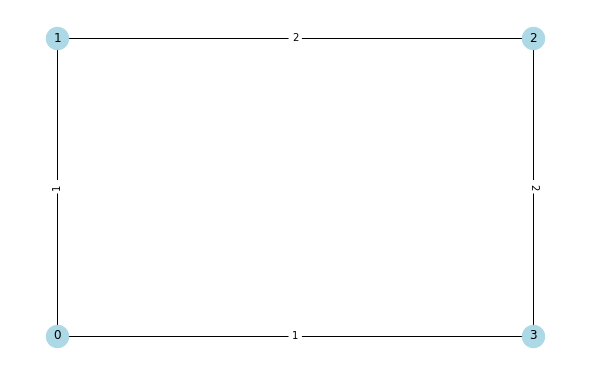

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from itertools import combinations, groupby
from qiskit import QuantumCircuit
from qiskit.tools.visualization import circuit_drawer
from qiskit.circuit import Parameter
# Number of nodes in the graph. Directly corresponds to the number of qubits
# Be careful and don't make this number too big, your computer may crash. 
# The classical computational cost of simulating this (on classical hardware),
# scales as 2^nodes. There is a reason that we need quantum computers!
nodes = 4

# Energy cost for having node occupied. It is negative so it is favourable for having this occupied.
weights_nodes = [-2,-2,-2,-2,-2,-2]

# Cost for having two connected nodes occupied. This may counteract the positive benefit (weights_nodes)
# for having the nodes occupied, and leads to the complexity for the problem.
weights_edges = [1,2,2,1]
edges = [(0,1), (1,2), (2,3), (3,0)]
pos = [(0,0),(0,2),(2,2),(2,0)]
random.seed(1)

G = nx.Graph()
for nn in range(0,nodes):
    G.add_nodes_from([(nn,{'weight': weights_nodes[nn]})])
    
iter = 0
for e in edges:
    G.add_edges_from([(e[0], e[1],{'weight': weights_edges[iter]})])
    iter += 1
labels = nx.get_edge_attributes(G,'weight')

plt.figure(figsize=(8,5))
nx.draw(G, node_color='lightblue', 
        with_labels=True, 
        node_size=500,pos = pos)

nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

Following what was mentioned at the beginning, the graph is created and the Hamiltonian of the problem is obtained.



# Exact Solution

In [9]:
import numpy as np
import scipy.sparse.linalg as sla
import copy

edges = np.zeros((len(G.edges()),2),dtype=int)
we = np.zeros(len(G.edges()),dtype=float)
iter = 0
for x in G.edges():
    edges[iter,0] = x[0]
    edges[iter,1] = x[1]
    we[iter] = G.edges[x]["weight"]
    iter = iter + 1

wn = np.zeros(len(G.nodes()),dtype=float)
iter = 0
for i in G.nodes():
    wn[iter] = G.nodes[i]["weight"]
    iter = iter + 1

def TensorProd(A):

    out = np.kron(A[0],A[1])
    for oo in range(2,len(A)):
        out = np.kron(out,A[oo])

    return out

sz = [[1.0,0.0],[0.0,-1.0]]

A0 = []
for n in range(0,nodes):
    A0.append(np.eye(2))

out = TensorProd(A0)

Ham = np.zeros((np.power(2,nodes),np.power(2,nodes)),dtype=float)

for p in range(0,len(G.edges())):
    A = copy.deepcopy(A0)
    A[edges[p][0]] = sz
    A[edges[p][1]] = sz
    Ham += we[p] * TensorProd(A)

Egs_exact, V = sla.eigs(Ham, 1, which='SR')

lex = ['0000','0001','0010','0011','0100','0101','0110','0111','1000','1001','1010','1011','1100','1101','1110','1111']

print("The cost of the optimal solution is "+str(np.real(Egs_exact[0])))
print("eigenstate: ")
for i in range(len(lex)):
      print('state ',lex[i],': ', np.round(V[i], decimals = 4))

The cost of the optimal solution is -5.999999999999994
eigenstate: 
state  0000 :  [-0.+0.j]
state  0001 :  [0.+0.j]
state  0010 :  [-0.+0.j]
state  0011 :  [-0.+0.j]
state  0100 :  [-0.+0.j]
state  0101 :  [0.3269+0.j]
state  0110 :  [0.+0.j]
state  0111 :  [-0.+0.j]
state  1000 :  [-0.+0.j]
state  1001 :  [-0.+0.j]
state  1010 :  [-0.9451+0.j]
state  1011 :  [0.+0.j]
state  1100 :  [0.+0.j]
state  1101 :  [0.+0.j]
state  1110 :  [-0.+0.j]
state  1111 :  [0.+0.j]


The minimum value of energy is $E = -6;$ which is related to the cut result, six. On the other hande the eigenstate associated to the optimal solution has the form $|\psi_{opt}\rangle =\left(a_0|0101\rangle + a_1|1010\rangle \right);$ this because both $0101$ and $1010$ are states that minimize the Hamiltonian and then are solutions of the maxcut problem.

## Quadratic Unconstrained Binary Optimization (QUBO)

Combinatorial optimization problems concerns to a big field of optimization problems that can be found in industry. In 2014, Kochenberger, et. al. discovered the formulation of what is known as Quadratic Unconstrained Binary Optimization (QUBO) problems; which can be used to described different problems in different fields, such as the travel salesman problem, Max-cut problems and more.


The fundamental formulation of a QUBO problem is expressed as the optimization of the following cost function
$$QUBO: Minimize/Maximize \hspace{1em}f(x) = x^T Q x$$

Here $x$ is a vector of binary variables and $Q$ is a square matrix of constants associated to the problem.

$$x = \begin{aligned}\begin{pmatrix}
x_0\\
x_1\\
\vdots\\
x_n
\end{pmatrix}\end{aligned}\hspace{1em}Q = \begin{aligned}\begin{pmatrix}
q_{00}&q_{01}&\dots&q_{0,n}\\
q_{10}&q_{11}&\dots&q_{1,n}\\
\vdots&\vdots&\ddots&\vdots\\
q_{n0}&q_{n1}&\dots&q_{nn}
\end{pmatrix}
\end{aligned}$$

The $Q$ matrix usually has a symetric or upper diagonal representation. Since $x_i^2 = x_i \forall i;$ the diagonal also concern to the linear terms.

### Constraints
Sometimes, binary problems have different constraints. In order to convert a binary problem to an unconstrained one (QUBO), we have the following table that covers some known penalties equivalent to a constraint in a binary problem.

|Classical constraint   |Equivalent Penalty with parameter $P$|
|:----------------------|:------------------------------------|
|$x_1+x_2\leq 1$        |$P(x_1x_2)$                          |
|$x_1+x_2\geq 1$        |$P(1 - x_1 - x_2 + x_1x_2)$          |
|$x_2+x_2 = 1$          |$P(1-x_1-x_2+2x_1x_2)$               |
|$x_1\leq x_2$          |$P(x_1-x_1x_2)$                      |
|$x_1 + x_2 + x_3\leq 1$|$P(x_1x_2 + x_1x_3+x_2x_3)$          |
|$x_1 =x_2 $            |$P(x_1 + x_2 - 2x_1x_2)$             |



We can model a maxcut problem by introducing binary variables such that $ x_j= 1$ if the node $j$ is in one set and $ x_j= 0$ if it is in the other set.

The problem of maximizing the number of edges in the cut can be formulated as

$$\text{Maximize}\hspace{1em}
f(x)=\sum_{(i, j) \in E} w_{ij}\left(x_{i}+x_{j}-2 x_{i} x_{j}\right).$$

With $w_{ij}$ being the weight of the cut between the nodes $i$ and $j.$

For the previous graph it is written as
$$\begin{aligned}
\text{Maximize} \hspace{1em}f(x) =&1(x_0 + x_1 - 2 x_0x_1)+\\
&2(x_1 + x_2 - 2 x_1x_2)+\\
&2(x_2 + x_3 - 2 x_2x_3)+\\
&1(x_0 + x_3 - 2 x_0x_3)
\end{aligned}$$

Can be rewritten as
$$\begin{aligned}
\text{Maximize} \hspace{1em}f(x) =&2x_0 + 3x_1 + 4x_2 + 3x_3 -\\
&2(x_0x_1 + 2x_1x_2 + 2x_2x_3 + x_0x_3)
\end{aligned}$$

The QUBO problem is then written as

$$QUBO: \text{Maximize} \hspace{1em} x^TQx.$$

Where $x^T = (x_0,x_1,x_2,x_3)$ and

$$Q = \begin{aligned}\begin{pmatrix}
2&  -1& 0& -1\\
-1& 3& -2&  0\\
0 & -2& 4& -2\\
-1& 0& -2& 3\\
\end{pmatrix}
\end{aligned}.$$

Now we build up a quadratic program equivalent to the previous QUBO problem using qiskit.

In [10]:
## Importing QuadraticProgram class
from qiskit_optimization import QuadraticProgram

## Define the QuadraticProgram
qp_mc = QuadraticProgram()

## Add variables
qp_mc.binary_var('x_0')
qp_mc.binary_var('x_1')
qp_mc.binary_var('x_2')
qp_mc.binary_var('x_3')

In [11]:
## Add objective function
qp_mc.maximize(linear={'x_0': 2, 'x_1': 3, 'x_2': 4,'x_3': 3},
            quadratic=[[0,-1,0,-1],[-1,0,-2,0],[0,-2,0,-2],[-1,0,-2,0]])

print(qp_mc.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Maximize
 obj: 2 x_0 + 3 x_1 + 4 x_2 + 3 x_3 + [ - 4 x_0*x_1 - 4 x_0*x_3 - 8 x_1*x_2
      - 8 x_2*x_3 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1

Binaries
 x_0 x_1 x_2 x_3
End



The solution of QUBO problems can be addressed using classical methods or quantum computing ones. In the case of qiskit we are using universal gate quantum computing, however, it can also be solved using quantum annealing methods. What you do in universal gate quantum computing is

$$
\overset{\mathrm{QUBO}}{x^TQx} \rightarrow\overset{\text{Ising Hamiltonian}}{H = \sum_i w_i Z_i + \sum_{ij}w_{ij}Z_i Z_j} \rightarrow \overset{\mathrm{Minimize}}{\langle \psi|H|\psi\rangle}_{\theta}$$

The ground state of the associated Ising Hamiltonian corresponds to the optimal solution of the problem. This ground state can be found by using quantum gate algorithms such as the Variational Quantum Eigensolver (VQE) or the Quantum Approximate Optimization Algorithm (QAOA). Here we are interested oin a QAOA algorithm.

# QAOA solution

To do this we first need to build up the Ising Hamiltonian equivalent to the problem. It is important to make use of a qiskit tool that will allow us to solve several problems. Once we have defined a QUBO problem we can find its Hamiltonian in the following way.

In [12]:
print(qp_mc.to_ising()[0])

1.0 * ZZII
+ 1.0 * IZZI
+ 0.5 * ZIIZ
+ 0.5 * IIZZ


Here the operators in the right are Pauli operators with its coefficients in the right. It is important to take into account that the indices of the spins associated to the Ising model go from right to left. Then, the Ising Hamiltonian of the problem is
$$
H_P = \frac{1}{2}\big(Z_0 \otimes Z_1 \otimes I_2 \otimes I_3\big) + 
        \frac{2}{2}\big(I_0 \otimes Z_1 \otimes Z_2 \otimes I_3\big) +
        \frac{1}{2}\big(Z_0 \otimes I_1 \otimes I_2 \otimes Z_3\big) +
        \frac{2}{2}\big(I_0 \otimes I_1 \otimes Z_2 \otimes Z_3\big)
$$

### Mixer Hamiltonian and Unitaries

The mixer Hamiltonian $H_B$ is usually of the form:

$$
H_B = \big(X_0 \otimes I_1 \otimes I_2 \otimes I_3 \big) + 
      \big(I_0 \otimes X_1 \otimes I_2 \otimes I_3 \big) +
      \big(I_0 \otimes I_1 \otimes X_2 \otimes I_3 \big) +
      \big(I_0 \otimes I_1 \otimes I_2 \otimes X_3 \big)
$$

As individual terms in the summation of $H_P$ and $H_B$ both commute, we can write the unitaries as:

$$ U(H_B) = e^{-i \beta H_B} = e^{-i \beta X_0}e^{-i \beta X_1}e^{-i \beta X_2}e^{-i \beta X_3}.$$

Notice that each term in the product above corresponds to an X-rotation on each qubit. And we can write $U(H_P)$ as:

$$ U(H_P) = e^{-i \gamma H_P} = e^{-i \gamma Z_0 Z_1}e^{-i \gamma Z_1 Z_2}e^{-i \gamma Z_2 Z_3}e^{-i \gamma Z_0 Z_3}$$

Let's now examine what the circuits of the two unitaries look like. 

### The Mixing Unitary

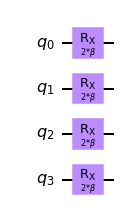

In [15]:
from qiskit import QuantumCircuit
from qiskit.tools.visualization import circuit_drawer
from qiskit.circuit import Parameter

nqubits = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw("mpl")

### The Problem Unitary

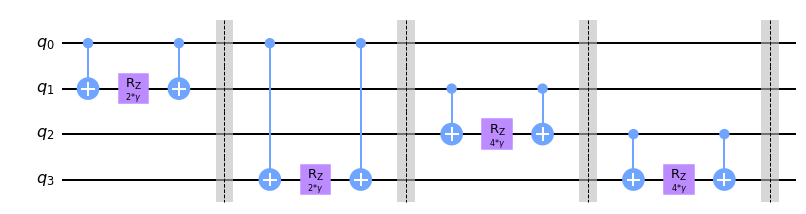

In [19]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma*G.edges[pair]["weight"], pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw("mpl")

### The Initial State

The initial state used during QAOA is usually an equal superposition of all the basis states i.e.

$$\lvert \psi_0 \rangle = \bigg(\frac{1}{\sqrt{2}}\big(\lvert 0 \rangle + \lvert 1 \rangle\big)\bigg)^{\otimes n}$$

Such a state, when number of qubits is 4 ($n=4$), can be prepared by applying Hadamard gates starting from an all zero state as shown in 
the circuit below. 

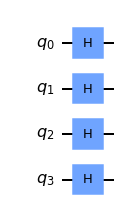

In [20]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw("mpl")

### The QAOA circuit

So far we have seen that the preparation of a quantum state during QAOA is composed of three elements
- Preparing an initial state
- Applying the unitary $U(H_P) = e^{-i \gamma H_P}$ corresponding to the problem Hamiltonian
- Then, applying the mixing unitary $U(H_B) = e^{-i \beta H_B}$

Let's see what it looks like for the example problem:

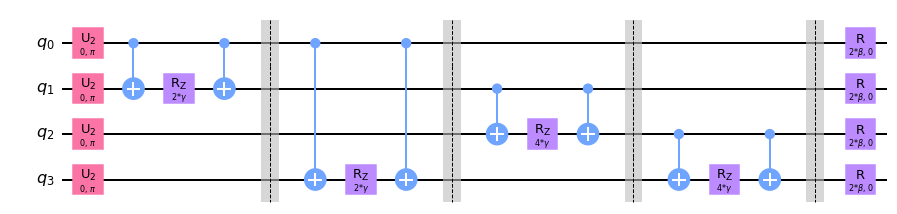

In [21]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw("mpl")

The next step is to find the optimal parameters $(\boldsymbol{\beta_{opt}}, \boldsymbol{\gamma_{opt}})$ such that the expectation value

$$ \langle \psi(\boldsymbol{\beta}_{opt}, \boldsymbol{\gamma}_{opt}) \rvert H_P \lvert 
\psi(\boldsymbol{\beta}_{opt}, \boldsymbol{\gamma}_{opt}) \rangle $$

is minimized. Such an expectation can be obtained by doing measurement in the Z-basis. We use a classical optimization algorithm to find the optimal parameters. Following steps are involved as shown in the schematic 

<img src="QAOA_schematic.png" width="600" height="200" class="center">

1. Initialize $\boldsymbol{\beta}$ and $\boldsymbol{\gamma}$ to suitable real values.
2. Repeat until some suitable convergence criteria is met:
    1. Prepare the state $\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle$ using qaoa circuit
    2. Measure the state in standard basis
    3. Compute $ \langle \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rvert H_P \lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle $ 
    4. Find new set of parameters $(\boldsymbol{\beta}_{new}, \boldsymbol{\gamma}_{new})$ using a classical optimization algorithm
    5. Set current parameters $(\boldsymbol{\beta}, \boldsymbol{\gamma})$ equal to the new parameters 
      $(\boldsymbol{\beta}_{new}, \boldsymbol{\gamma}_{new})$

The code below implements the steps mentioned above.

In [22]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= G.edges[(i,j)]["weight"]
            
    #return obj
    #for i, j in G.edges():
    #    if x[i] == x[j] and x[i] == "1":
    #        obj += G.edges[(i,j)]["weight"]

    #for i in G.nodes():
    #    if x[i] == "1":
    #        obj += G.nodes[i]["weight"]
            
    return obj
            

def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        #for nod in list(G.nodes()):
        #    qc.rz(2 * gamma[irep]*G.nodes[nod]["weight"], nod)
            
            
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep]*G.edges[pair]["weight"], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, backend, shotsin,seed):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)

        # We need this step if we want to run on hardware. 
        # tqc = qiskit.compiler.transpile(qc,backend)
        tqc = qc

        counts = backend.run(tqc, seed_simulator=seed,shots = shotsin).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [23]:
from scipy.optimize import minimize
from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA

backend = Aer.get_backend('qasm_simulator')

# Max number of optimisation iterations
maxiter = 100

p = 1
theta0 = [1.0, 1.0,1.0,1.0]

# Number of quantum measurements each time the quantum circuit is called
shotsin = 100

# We have random outcomes for the measurements.
# So for the simulation it is good practice to seed the random number generator
seed = 2

expectation = get_expectation(G, backend, shotsin,seed)

options = {'maxiter': maxiter}
res = minimize(expectation,theta0,options=options,method='COBYLA')

res

     fun: -5.37
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 45
  status: 1
 success: True
       x: array([1.12946567, 2.32957426, 2.66792412, 0.2284215 ])

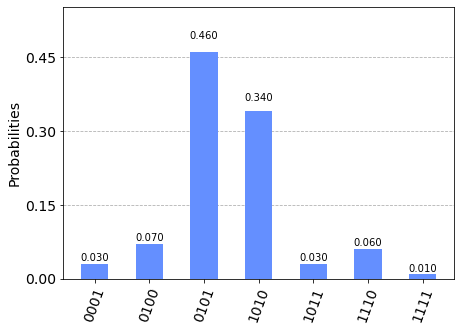

In [24]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=seed,shots = shotsin).result().get_counts()

plot_histogram(counts)

In [25]:
task_price = 0.25 # price for submitting task to system (in dollars)

price_per_CNOT = 0.0001 # price for a single CNOT gate (in dollars)
price_per_Zrot = 0.00003 # price for a single Z rotation (in dollars)
price_per_Xrot = 0.00008 # price for a single X rotation (in dollars)

price_per_shot = p * (len(G.edges()) * (2* price_per_CNOT + price_per_Zrot) + len(G.nodes()) * price_per_Xrot)

Optim_evals = res.nfev # Number of optimization steps i.e. the number of times the quantum hardware was called.
Meas_shots = shotsin # Number of measurements of quantum hardware i.e. number of times the circuit was applied to the hardware.

Cost = (Optim_evals * shotsin * price_per_shot) + task_price

print("The estimated cost is = $"+str(Cost))

The estimated cost is = $5.83


The cost of the simulation can be reduced by changing the parameters of the QAOA circuit. In this case we decided to change the ammount of shots of the circuit. This variable can be reduced depending on the ammount of qubits needed to simulate the circuit. Since here we have 4 qubits there are $2^{4}$ possible states. The number of shots has to be chossen taking into account the ammount of possible states.

There is also an important thing to take into account. The formulation presented here works well for Maxcut problems such that they have positive weights in their edges. In the paper written by F. Barahona in 1998 and cited bellow, There is a Maxcut problem that can be associated to a spin glass model. However, it corresponds to a maxcut problem with negative weights. When we tried to solve that problem with a QAOA algorithm we found an answer without sense. This is because with negative weights it is important to define some constraints to the problem, which can be converted in a QUBO problem with more binary variables.

# References
* F. Glover, G. Kochenberger, Y. Du (2019). "A Tutorial on Formulating and Using QUBO Models". arXiv preprint arXiv:1811.11538v6.

* G. Kochenberger, J-K. Hao, F. Glover, M. Lewis, Z. Lu, H. Wang, Y. Wang "The Unconstrained Binary Quadratic Programming Problem: A Survey”. Journal of Combinatorial Optimization, Vol. 28, Issue 1, pp. 58-81.

* Qiskit Community (2022). "Qiskit: An Open-source Framework for Quantum Computing". 10.5281/zenodo.2573505.

* F. Barahona, M. Grötschel, M. Jünger, G. Reinelt, (1998). "An Application of Combinatorial Optimization to Statistical Physics and Circuit Layout Design". Operations Research 36(3):493-513. http://dx.doi.org/10.1287/opre.36.3.493.
